In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [45]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all railway linestrings.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])        

def tram_network(osm_path):
    """
    Extracts tram network data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing tram network data extracted from the OpenStreetMap file.
    """

    # Extract railway data from the OpenStreetMap file
    df_railway = railway(osm_path)
    
    # Filter the DataFrame to only contain tram network data
    tram = df_railway.loc[df_railway.railway == 'tram']
    
    # Return the filtered DataFrame
    return tram

def railway_stations(osm_path):
    """
    Function to extract tram station nodes from OpenStreetMap.  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
    """   
    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'name']))  #,'railway'

def tram_stations(osm_path):

    df_railway_stations = railway_stations(osm_path)
    
    tram_stations = df_railway_stations.loc[df_railway_stations.tram == 'yes']
    tram_stations = tram_stations.loc[tram_stations.public_transport == 'stop_position']
    
    return tram_stations

def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'to', 'name', 'ref'])#,'from'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

In [3]:
def am_tram_stations(stations):
    
# Add columns for the x and y coordinates of each station
    stations['geo_x'] = stations.geometry.x
    stations['geo_y'] = stations.geometry.y
    
    # Drop duplicate stations and rename the two 'Centraal Station' stations as 'Centraal Station_A' and 'Centraal Station_B'
    sorted_stations = stations.sort_values(by='geo_x')
    stations_drop = sorted_stations[sorted_stations['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB.iloc[0, 3] = 'Centraal Station_B'
    # station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = pd.DataFrame(station_cetralA)
    station_cetralA.iloc[0, 3] = 'Centraal Station_A'
    
    # Create DataFrames for the stations and concatenate them into one DataFrame
    df_stations_drop = pd.DataFrame(stations_drop)
    df_station_cetralB = pd.DataFrame(station_cetralB)
    df_station_cetralA = pd.DataFrame(station_cetralA)
    tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
    
    return tram_stations

# Create s_e_tram_coordinates_pairs dataframe combining data of all stations and names of start-end stations    
def s_e_tram_coordinates(am_tram_stations, s_e_tram_station_name):
    """
    Given a GeoDataFrame `stations` containing information about tram stations and a DataFrame `s_e_tram_station_name` 
    containing pairs of tram station names, returns a new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, 
    `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Parameters
    ----------
    stations : geopandas.GeoDataFrame
        A GeoDataFrame containing information about tram stations, including the `geometry` column with the latitude 
        and longitude coordinates of each station.
    s_e_tram_station_name : pandas.DataFrame
        A DataFrame containing pairs of tram station names, with columns `s_name` and `e_name`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and 
        `e_coordinates_y`. `s_name` and `e_name` are the names of the starting and ending tram stations, respectively, 
        and `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y` are the coordinates of the 
        starting and ending tram stations.
    """
    
    # Create s_e_tram_coordinates DataFrame by compare station names 
    df31 = pd.merge(s_e_tram_station_name, am_tram_stations, how='left', left_on='s_name', right_on='name')
    s_e_tram_coordinates = pd.merge(df31, am_tram_stations, how='left', left_on='e_name', right_on='name')
    s_e_tram_coordinates = s_e_tram_coordinates.loc[:,['s_name', 'e_name', 'geo_x_x', 'geo_y_x', 'geo_x_y', 'geo_y_y']]
    s_e_tram_coordinates.columns = ['s_name', 'e_name', 's_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']
    
    return s_e_tram_coordinates

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a shapely geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from shapely import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the shapely and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = shapely.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(shapely.points(coordinate))
    elif isinstance(coordinate, shapely.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = shapely.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = shapely.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs

In [4]:
# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G

# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs

# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges

# Calculate maximum flow for each route and draw each of them with linewidth of 'capacity'
def max_flow_am_tram (edges, nodes, route_capacity, id_pairs, G):
    """
    Calculate the maximum flow through a network, given the edges and nodes information of the network, the capacity of the routes, the start and end node pairs, and the Graph object G.
    Args:
        edges (pandas.DataFrame): A DataFrame containing information about the edges of the network, including the from_id, to_id, and capacity of each edge.
        nodes (pandas.DataFrame): A DataFrame containing information about the nodes of the network.
        route_capacity (pandas.Series): A Series containing the capacity of each route in the network.
        id_pairs (pandas.DataFrame): A DataFrame containing the start and end node pairs of each route in the network.
        G (networkx.classes.graph.Graph): The Graph object representing the network.
    Returns:
        edges: A pandas DataFrame that contains information about edges in a graph, including the from_id, to_id, weight, and capacity columns.
        route_edges: A pandas DataFrame that contains information about edges on the shortest path between source and target node pairs, including the from_id, to_id, weight, and capacity columns.
        flow_value_dict: A pandas DataFrame that contains information about flow values between source and target node pairs, including the source, target, and flow columns.
        flow_value: A float value that represents the maximum flow value in the graph.

    The function adds the capacity of each route to the corresponding edges of the network. Then, it creates a new networkx Graph object, G_max, based on the updated edge capacity information. Afterward, it calculates the maximum flow through G_max using the networkx maximum_flow function.
    """
    edges['capacity'] = 0
    
    fig, axes = plt.subplots(7, 2,figsize=(15,15))
    for i, ax in enumerate(axes.flat):
        if i < 14:
            route, route_weight, route_edges = shortest_path(G, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'], edges, weight = "weight")
            route_edges['capacity'] = 0
            route_edges['capacity'] = route_capacity.iloc[i, 0]
            #print(route_edges)
            common_edges = set(route_edges['to_from']).intersection(set(edges['to_from'])) \
                    .union(set(route_edges['from_to']).intersection(set(edges['from_to'])))
            edges.loc[edges['to_from'].isin(common_edges) | edges['from_to'].isin(common_edges), 'capacity'] = edges['capacity'] + route_capacity.iloc[i, 0]
            #print(edges)
        
        if i == 0:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red', linewidth=route_edges['capacity'])
            ax.set_title('Route 1')
        elif i == 1:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 2')
        elif i == 2:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 3')
        elif i == 3:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 4')
        elif i == 4:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 5')
        elif i == 5:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 7')
        elif i == 6:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 12')
        elif i == 7:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 13')
        elif i == 8:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 14')
        elif i == 9:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 17')
        elif i == 10:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 19')
        elif i == 11:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 24')
        elif i == 12:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 25')
        elif i == 13:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 26')
        else:    
            ax.axis('off')
        ax.axis('off')

    plt.show()
    
    od = edges[['from_id', 'to_id', 'capacity']]
    edges_list = []
    for i, row in od.iterrows():
        capacity_dict = {"capacity": row[2]}
        tuple_row = (row[0], row[1], capacity_dict)
        edges_list.append(tuple_row)
    #edges_list
    nodes_list = nodes.iloc[:,2].tolist()
    G_max = nx.Graph()
    G_max.add_nodes_from(nodes_list)
    G_max.add_edges_from(edges_list)
    
    for i, ax in enumerate(axes.flat):
        if i < 14:
            flow_value, flow_dict = nx.maximum_flow(G_max, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'])
            flow_value_dict = pd.DataFrame(columns=["source", "target", "flow"])
            for source, targets in flow_dict.items():
                for target, flow in targets.items():
                    flow_value_dict = flow_value_dict.append({"source":source, "target":target, "flow":flow}, ignore_index=True)
            print(flow_value_dict)
            print("Maximum flow:", flow_value)
    
    return edges, route_edges, flow_value_dict, flow_value


# Creat the dataset of 'edges' after delete some edges randomly
def missing_edges(edges, e_num):
    missing_edges = random.sample(list(edges.index), e_num)
    edges = edges.drop(missing_edges)
    return edges

## Step1: get data of edges, nodes all tram stations from OSM map

In [5]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [6]:
am_all_tram_stations = tram_stations(osm_path)

In [7]:
am_all_tram_stations.to_excel('./am_all_tram_stations.xlsx',header = True, index = False)  

In [8]:
gpd.GeoDataFrame(am_all_tram_stations.copy()).to_file('am_all_tram_stations.GPKG',driver='GPKG')

In [9]:
tram = tram_network(osm_path)

In [10]:
edges,nodes = prepare_network(tram,am_all_tram_stations)

topology: 100%|██████████████████████████████████████████████████████████████████| 2136/2136 [00:00<00:00, 9029.41it/s]


In [11]:
edges = expand_edges(edges)

In [12]:
gpd.GeoDataFrame(edges[['geometry','id','from_id','to_id']].copy()).to_file('edges_tram_amsterdam.GPKG',driver='GPKG')

In [13]:
gpd.GeoDataFrame(nodes[['geometry','id']].copy()).to_file('nodes_tram_amsterdam.GPKG',driver='GPKG')

## Test 3-Step 6: find all stations and caculate shortest path between all stations - including Test1-Step2 to Step5

In [14]:
am_tram_stations = am_tram_stations(am_all_tram_stations)

In [15]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [16]:
gpd.GeoDataFrame(am_tram_stations.copy()).to_file('am_tram_stations.GPKG',driver='GPKG')

In [17]:
am_tram1_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram1_name.xlsx', header=None)
am_tram2_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram2_name.xlsx', header=None)
am_tram3_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram3_name.xlsx', header=None)
am_tram4_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram4_name.xlsx', header=None)
am_tram5_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram5_name.xlsx', header=None)
am_tram7_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram7_name.xlsx', header=None)
am_tram12_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram12_name.xlsx', header=None)
am_tram13_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram13_name.xlsx', header=None)
am_tram14_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram14_name.xlsx', header=None)
am_tram17_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram17_name.xlsx', header=None)
am_tram19_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram19_name.xlsx', header=None)
am_tram24_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram24_name.xlsx', header=None)
am_tram25_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram25_name.xlsx', header=None)
am_tram26_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram26_name.xlsx', header=None)

In [18]:
am_tram_name_dict = {'am_tram_name1':am_tram1_name,
                     'am_tram_name2':am_tram2_name,
                     'am_tram_name3':am_tram3_name,
                     'am_tram_name4':am_tram4_name,
                     'am_tram_name5':am_tram5_name,
                     'am_tram_name7':am_tram7_name,
                     'am_tram_name12':am_tram12_name,
                     'am_tram_name13':am_tram13_name,
                     'am_tram_name14':am_tram14_name,
                     'am_tram_name17':am_tram17_name,
                     'am_tram_name19':am_tram19_name,
                     'am_tram_name24':am_tram24_name,
                     'am_tram_name25':am_tram25_name,
                     'am_tram_name26':am_tram26_name}

for key,value in am_tram_name_dict.items():
    value.columns = ['s_name']
    value['e_name'] = value['s_name'].shift(-1)
    am_tram_name_dict[key] = value.iloc[:-1]

In [19]:
am_tram_coordinates = am_tram_name_dict.copy()
am_tram_coordinates_pairs = am_tram_name_dict.copy()
am_tram_id_pairs = am_tram_name_dict.copy()

In [20]:
for line in am_tram_name_dict.keys():
    am_tram_coordinates[line] = s_e_tram_coordinates(am_tram_stations,am_tram_name_dict[line])
    am_tram_coordinates_pairs[line] = s_e_coordinates_pairs(am_tram_coordinates[line])
    am_tram_id_pairs[line] = id_pairs(am_tram_coordinates_pairs[line],nodes)

In [56]:
am_tram_name_dict['am_tram_name7']

,s_name,e_name
0,Sloterpark,Burgemeester Roëllstraat
1,Burgemeester Roëllstraat,Plein '40-'45
2,Plein '40-'45,Burgemeester Eliasstraat
3,Burgemeester Eliasstraat,Burgemeester Fockstraat
4,Burgemeester Fockstraat,Burgemeester de Vlugtlaan
5,Burgemeester de Vlugtlaan,Bos en Lommerplein
6,Bos en Lommerplein,Jan van Galenstraat
7,Jan van Galenstraat,Mercatorplein
8,Mercatorplein,W. Schoutenstraat
9,W. Schoutenstraat,Hoofdweg


In [21]:
G = create_ground_graph(edges, nodes)

In [22]:
am_tram_shortest_path_pairs = am_tram_id_pairs.copy()
duplicate_row_count = am_tram_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_id_pairs.copy()
am_tram_edges = am_tram_id_pairs.copy()

In [23]:
for line in am_tram_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [24]:
# am_tram_shortest_path_pairs['am_tram_name7']
# am_tram_shortest_path_pairs['am_tram_name7'].to_excel('./am_tram_shortest_path_pairs_tram_name7.xlsx',header = True, index = False)

# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_name7'].copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_name7']['count_weight'])*2)

In [25]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_name24'].copy()).plot(ax=ax,color='black',zorder=1)#,linewidth=(am_tram_shortest_path_edges['am_tram_name25']['count_weight'])*2)

In [26]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

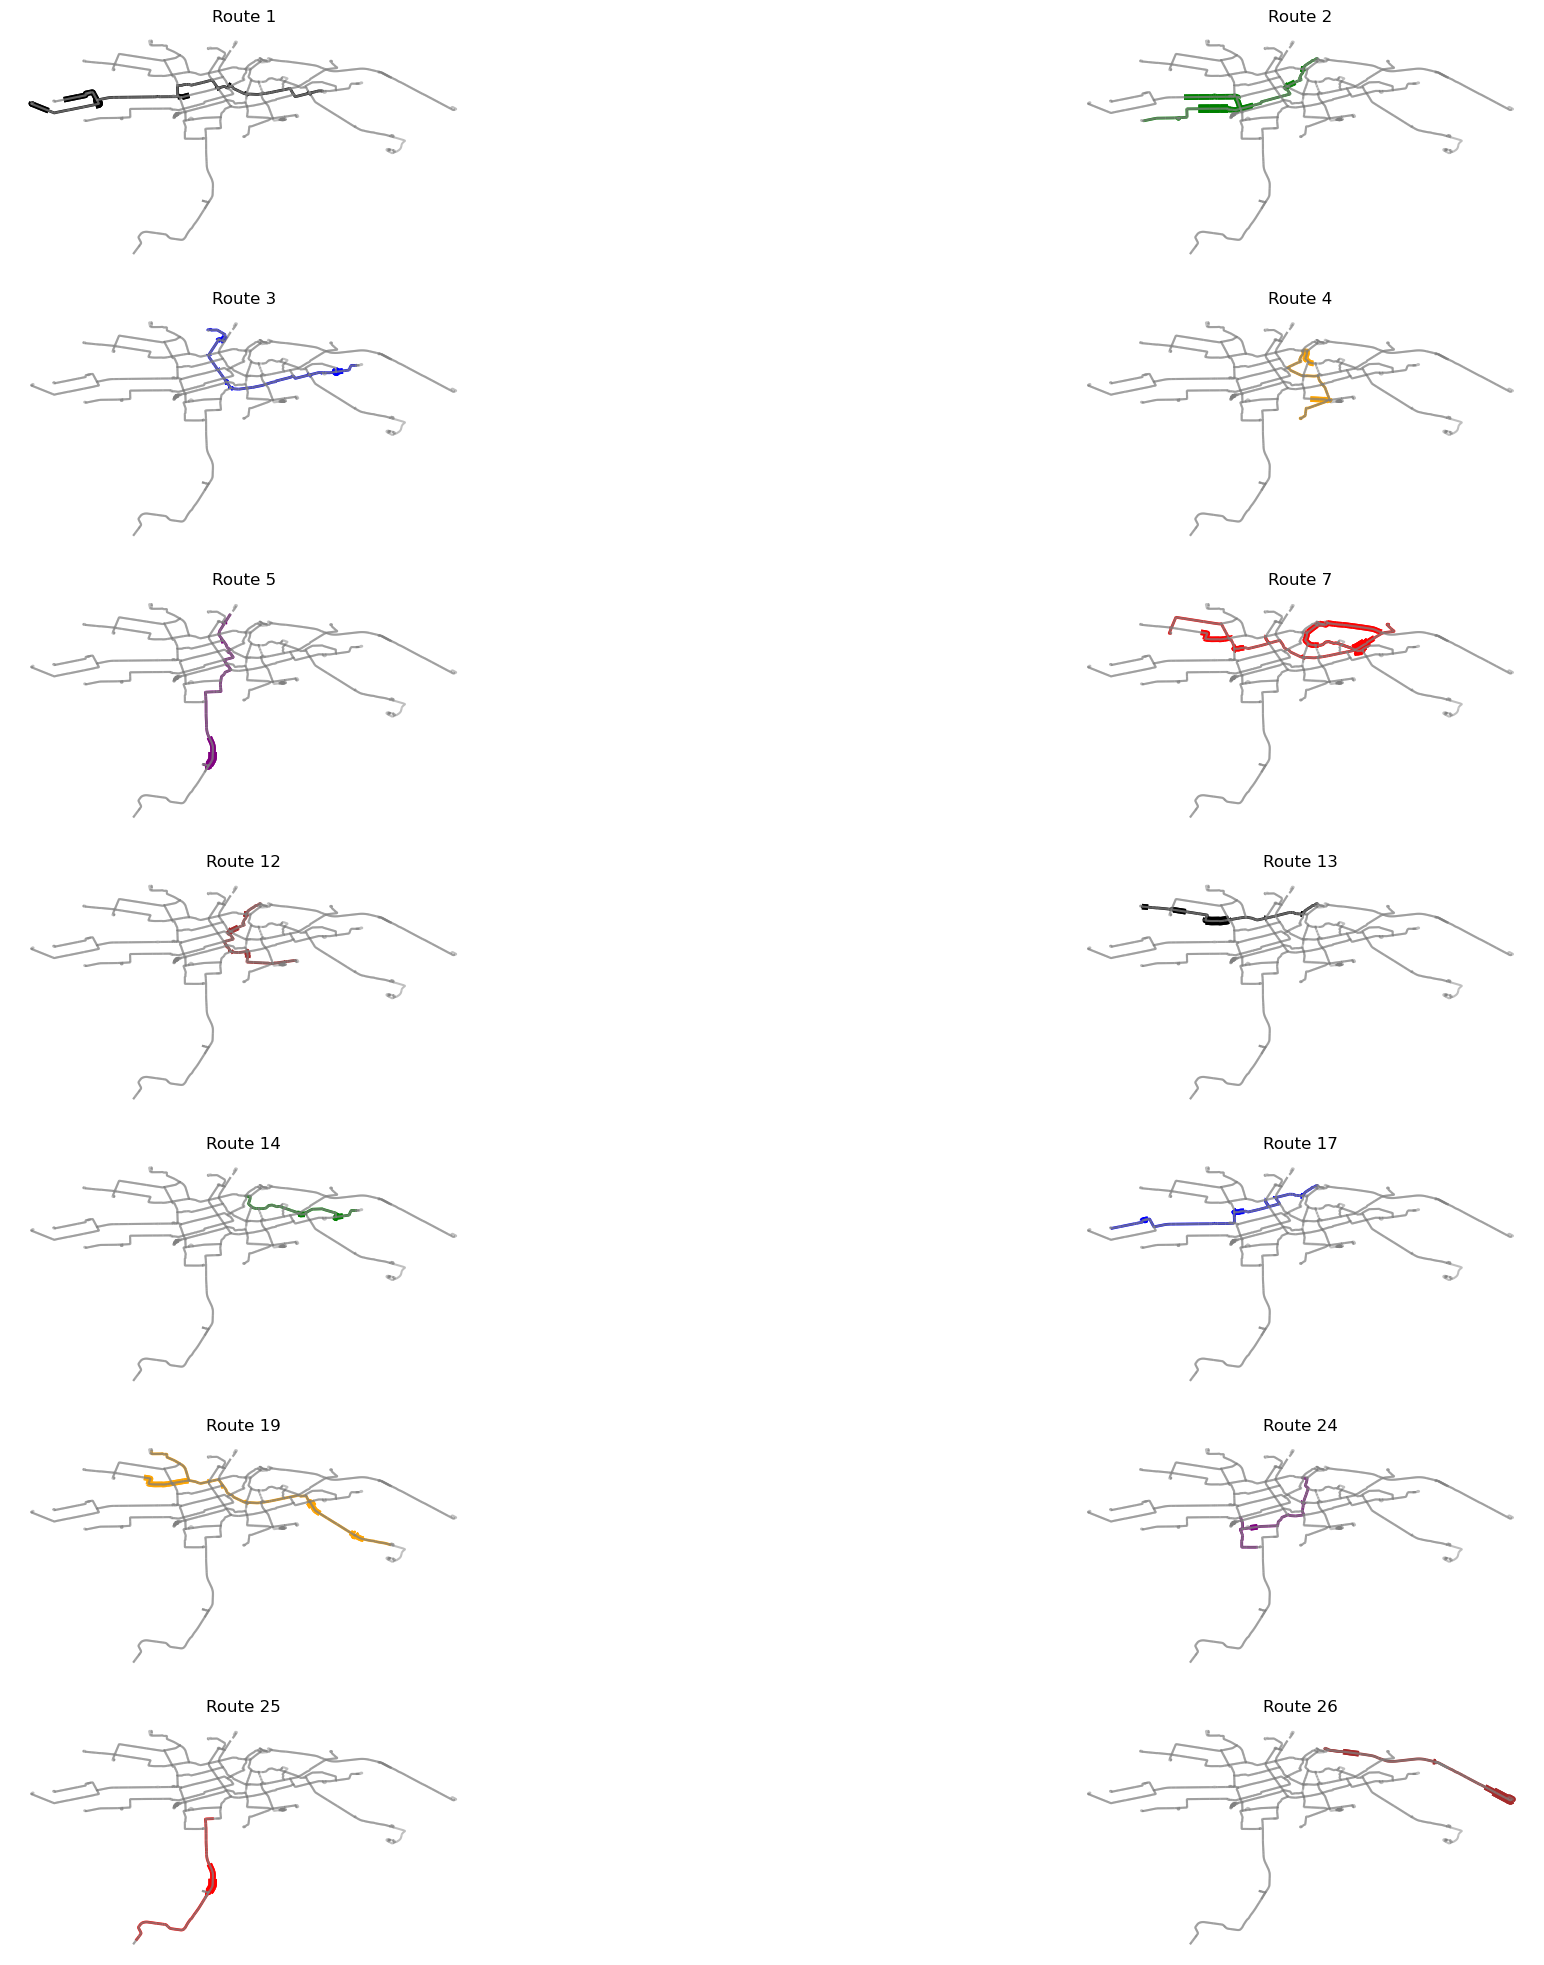

In [27]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

## Test 2-retrive routes compare with edges - but not working May---try to compare with nodes  June

In [46]:
all_routes = routes(osm_path)

In [54]:
tram_routes = pd.DataFrame(all_routes.loc[all_routes.route == 'tram'])
tram_routes = tram_routes.loc[tram_routes.ref != 'EMA']
tram_routes['ref'] = tram_routes['ref'].astype(int)
tram_routes = tram_routes.sort_values('ref')
tram_routes['to'] = tram_routes['to'].str.replace('Amsterdam,', '')
tram_routes['to'] = tram_routes['to'].str.replace('Diemen,', '')
tram_routes

,osm_id,route,to,name,ref,geometry
626,8507592,tram,Osdorp De Aker,Tram 1: Amsterdam Muiderpoortstation =>Amsterd...,1,"MULTILINESTRING ((4.93261 52.36080, 4.93252 52..."
622,8500553,tram,Muiderpoortstation,Tram 1: Amsterdam Osdorp de Aker => Amsterdam ...,1,"MULTILINESTRING ((4.77476 52.35373, 4.77655 52..."
14,31530,tram,Oudenaardeplantsoen,Tram 2: Amsterdam Centraal Station => Amsterda...,2,"MULTILINESTRING ((4.81102 52.34641, 4.81118 52..."
354,4497721,tram,Centraal Station,Tram 2: Amsterdam Nieuw Sloten => Amsterdam Ce...,2,"MULTILINESTRING ((4.80985 52.34614, 4.81032 52..."
617,8494828,tram,Van Hallstraat,Tram 3: Amsterdam Flevopark => Amsterdam Weste...,3,"MULTILINESTRING ((4.95106 52.36525, 4.95096 52..."
616,8493327,tram,Flevopark,Tram 3: Amsterdam Westergasfabriek => Amsterda...,3,"MULTILINESTRING ((4.86985 52.38426, 4.86988 52..."
15,31794,tram,Drentepark,Tram 4: Amsterdam Centraal Station => Amsterda...,4,"MULTILINESTRING ((4.89406 52.37387, 4.89361 52..."
353,4494870,tram,Centraal Station,Tram 4: Amsterdam Station RAI => Amsterdam Cen...,4,"MULTILINESTRING ((4.88956 52.33608, 4.88962 52..."
621,8500345,tram,"Amstelveen, Stadshart",Tram 5: Amsterdam Eerste Marnixdwarsstraat => ...,5,"MULTILINESTRING ((4.88041 52.35868, 4.88054 52..."
620,8500223,tram,Eerste Marnixdwarsstraat,Tram 5: Amstelveen Stadshart => Amsterdam Eers...,5,"MULTILINESTRING ((4.86656 52.30142, 4.86662 52..."


In [33]:
# gpd.GeoDataFrame(tram_routes.copy()).to_file('tram_routes_amsterdam.gpkg',driver='GPKG')

In [70]:
am_tram_stations_dict = {'am_tram_line1_0':0,
                         'am_tram_line1_1':1,
                         'am_tram_line2_0':2,
                         'am_tram_line2_1':3,
                         'am_tram_line3_0':4,
                         'am_tram_line3_1':5,
                         'am_tram_line4_0':6,
                         'am_tram_line4_1':7,
                         'am_tram_line5_0':8,
                         'am_tram_line5_1':9,
                         'am_tram_line7_0':10,
                         'am_tram_line7_1':11,
                         'am_tram_line12_0':12,
                         'am_tram_line12_1':13,
                         'am_tram_line13_0':14,
                         'am_tram_line13_1':15,
                         'am_tram_line14_0':16,
                         'am_tram_line14_1':17,
                         'am_tram_line17_0':18,
                         'am_tram_line17_1':19,
                         'am_tram_line19_0':20,
                         'am_tram_line19_1':21,
                         'am_tram_line24_0':22,
                         'am_tram_line24_1':23,
                         'am_tram_line25_0':24,
                         'am_tram_line25_1':25,
                         'am_tram_line26_0':26,
                         'am_tram_line26_1':27}

In [64]:
am_all_tram_stations= gpd.GeoDataFrame(am_all_tram_stations.copy())

In [ ]:
['name', 'geo_x', 'geo_y']

In [72]:
am_tram_stations_inline_dict = am_tram_stations_dict.copy()

for key,value in am_tram_stations_inline_dict.items():
    value1 = value
    value2 = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[value1].geometry.buffer(0.00000001))]
    am_tram_stations_inline_dict[key] = value2

am_tram_stations_inline_dict

{'am_tram_line1_0':           osm_id public_transport tram                              name  \
 109    237962650    stop_position  yes                      Dapperstraat   
 121    241775832    stop_position  yes                       Rijksmuseum   
 176    290957004    stop_position  yes                     Surinameplein   
 258    427560648    stop_position  yes                      Weesperplein   
 284    434441207    stop_position  yes         Korte 's-Gravesandestraat   
 285    434441216    stop_position  yes                      Vijzelgracht   
 293    434507138    stop_position  yes                    Linnaeusstraat   
 299    434524959    stop_position  yes                         Beukenweg   
 303    434598999    stop_position  yes                           Pilatus   
 304    434599001    stop_position  yes                       Inaristraat   
 318    434646764    stop_position  yes              Rhijnvis Feithstraat   
 817    881345030    stop_position  yes                  

In [51]:
am_all_tram_line7_Slotermeer = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[10].geometry.buffer(0.00000001))]
# am_all_tram_line7_Slotermeer = am_all_tram_line7_Slotermeer.sort_values('geo_x')
am_all_tram_line7_Slotermeer

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
121,241775832,stop_position,yes,Rijksmuseum,POINT (4.88710 52.36097),4.887104,52.360973
173,290931857,stop_position,yes,Postjesweg,POINT (4.85318 52.36477),4.853179,52.364773
199,297099562,stop_position,yes,Azartplein,POINT (4.93732 52.37661),4.937322,52.376613
234,330028855,stop_position,yes,Eerste Leeghwaterstraat,POINT (4.92940 52.37008),4.929398,52.370077
258,427560648,stop_position,yes,Weesperplein,POINT (4.90712 52.36100),4.907121,52.361002
282,434414719,stop_position,yes,C. van Eesterenlaan,POINT (4.93885 52.37357),4.938846,52.373567
283,434430962,stop_position,yes,Alexanderplein,POINT (4.91924 52.36387),4.919237,52.363873
284,434441207,stop_position,yes,Korte 's-Gravesandestraat,POINT (4.91359 52.36235),4.913592,52.362348
285,434441216,stop_position,yes,Vijzelgracht,POINT (4.89210 52.35951),4.892102,52.359505
314,434614443,stop_position,yes,Jan Pieter Heijestraat,POINT (4.86294 52.36488),4.862943,52.364882


In [52]:
len(am_all_tram_line7_Slotermeer)

30

In [ ]:
am_tram_coordinates_line7 = ['column1'='name','column2'='']

In [53]:
am_all_tram_line7_Azartplein = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[11].geometry.buffer(0.00000001))]
am_all_tram_line7_Azartplein = am_all_tram_line7_Azartplein.sort_values('geo_x')
am_all_tram_line7_Azartplein

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
936,1582427256,stop_position,yes,Sloterpark,POINT (4.81860 52.37284),4.818602,52.372845
979,1716142293,stop_position,yes,Burgemeester Roëllstraat,POINT (4.81946 52.37666),4.819457,52.376660
593,721160643,stop_position,yes,Plein '40-'45,POINT (4.82252 52.38123),4.822524,52.381225
608,721160810,stop_position,yes,Burgemeester Eliasstraat,POINT (4.82750 52.38045),4.827504,52.380451
610,721160815,stop_position,yes,Burgemeester Fockstraat,POINT (4.83324 52.37955),4.833240,52.379551
579,721160483,stop_position,yes,Burgemeester de Vlugtlaan,POINT (4.83829 52.37876),4.838294,52.378758
3131,6841407500,stop_position,yes,Bos en Lommerplein,POINT (4.84645 52.37720),4.846450,52.377199
1342,3300515588,stop_position,yes,Jan van Galenstraat,POINT (4.84872 52.37298),4.848724,52.372983
3113,6841269796,stop_position,yes,Mercatorplein,POINT (4.85007 52.37041),4.850068,52.370406
1381,3307835928,stop_position,yes,W. Schoutenstraat,POINT (4.85236 52.36739),4.852361,52.367389


In [54]:
len(am_all_tram_line7_Azartplein)

29

In [ ]:
am_all_tram_line1_OM = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[22].geometry.buffer(0.00001))]
am_all_tram_line1_OM

In [ ]:
len(am_all_tram_line1_OM)

In [ ]:
am_all_tram_line1_OM2 = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[22].geometry.buffer(0.0000000001))]
am_all_tram_line1_OM2

In [ ]:
len(am_all_tram_line1_OM2)

In [ ]:
am_all_tram_line1_OM1 = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[22].geometry)]
am_all_tram_line1_OM1

In [ ]:
len(am_all_tram_line1_OM1)

In [ ]:
am_all_tram_line14_OM = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[24].geometry.buffer(0.000001))]
am_all_tram_line14_OM

In [ ]:
len(am_all_tram_line14_OM)

### retrive routes compare with edges - but not working May

In [ ]:
tram_routes['each_line'] = tram_routes.geometry.apply(lambda x: [Line for Line in x])
# tram_routes

In [ ]:
edges.geometry = edges.geometry.apply(shapely.to_shapely)  #因为tram_routes中是shapely格式
edges['route'] = ''

In [ ]:
edges

In [ ]:
edges.to_excel('./am_tram_edges.xlsx',header = True, index = False)  
tram_routes.to_excel('./am_tram_routes.xlsx',header = True, index = False)  

In [ ]:
# 将route的ref添加进edges的route列
# 问题可能出在：edges中geometry的linestring部分存在在tram_routes中each_line的multilinestring中， 比如第1005行

In [ ]:
# 方法1
# df_edges=pd.merge(edges,tram_routes,how='left',left_on='geometry',right_on='each_line')
# df_edges=df_edges.loc[:,['osm_id','gemotry','railway','service','id','from_id','to_id','distance','time','weights','to_from','from_to','ref']]
# df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
# df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]

In [ ]:
# 方法2
# for n in range(len(tram_routes)):
#     b = gpd.GeoSeries(tram_routes.each_line.iloc[n])
#     for i in range(len(edges)):
#         a = gpd.GeoSeries(edges.geometry.iloc[i])
#         if a.within(b).all():
#             edges.route.iloc[i] = tram_routes.ref.iloc[n]

In [ ]:
# 方法3
#edges['is_on_tram_route'] = edges['geometry'].apply(lambda x: any(x.intersects(route) for route in tram_routes['each_line']))

In [ ]:
#方法4
# for idx, row in edges.iterrows():
#     for each_line in tram_routes.loc['each_line'].tolist():
#         if row['geometry'] in each_line:
#             # 如果第二个表格中的geometry对象在第一个表格中的LineString列表中，则将该行的ref列添加到第二个表格中的对应行中
#             edges.at[idx, 'route'] = tram_routes.loc[tram_routes['each_line'] == each_line, 'ref'].iloc[0]

In [ ]:
for n in range(len(tram_routes)):
    t = 0
    b = tram_routes.each_line.iloc[n]
    t = t + n
    print(t)

In [ ]:
# 方法0
for i in range(len(edges)):
    a = edges.geometry.iloc[i]
    
    for n in range(len(tram_routes)):
        b = tram_routes.each_line.iloc[n]
        c = a in b
        if c > 0:
            edges.route.iloc[i] = tram_routes.ref.iloc[n]      

In [ ]:
#方法0.0
for i in range(len(edges)):
    a = edges.loc[i,'geometry']
    
    for n in range(len(tram_routes)):
        b = tram_routes.iloc[n,tram_routes.columns.get_loc('each_line')]
        if a in b:
            edges.loc[i,'route'] = tram_routes.iloc[n,tram_routes.columns.get_loc('ref')]

In [ ]:
edges

In [ ]:
edges = edges.loc[edges.route != '']
edges

In [ ]:
edges1 = edges.loc[edges.route == '1']
edges1

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges1.copy()).plot(ax=ax,zorder=0)

In [ ]:
a = edges.geometry.loc[0] 
b = tram_routes.each_line.loc[622]
c = tram_routes.each_line.loc[626]

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))


# gpd.GeoSeries(a).plot(ax=ax,zorder=0)
# gpd.GeoSeries(b).plot(ax=ax,color='black',zorder=1)
# gpd.GeoSeries(c).plot(ax=ax,color='blue',zorder=2)

In [ ]:
type(a)

In [ ]:
b

In [ ]:
# a = shapely.to_shapely(a)
# a

In [ ]:
a in c

In [ ]:
a in b

In [ ]:
d = edges.geometry.loc[1006]
e = tram_routes.each_line.loc[18]
f = tram_routes.each_line.loc[357]

In [ ]:
d in e

In [ ]:
d in f

In [ ]:
edges.geometry = gpd.GeoDataFrame(edges.copy()).geometry.apply(lambda x: Point(x.coords[0]))
tram_routes.each_line = gpd.GeoDataFrame(tram_routes.copy()).geometry.apply(lambda x: Point(x.coords[0]))

# 对于每个edges的坐标点，判断是否在tram_routes中存在
for index, row in edges.iterrows():
    point = row.geometry
    ref_value = tram_routes[tram_routes.intersects(point)].ref.unique()
    
    # 如果存在，则将ref列的值添加到edges中
    if len(ref_value) > 0:
        edges.at[index, 'ref'] = ref_value[0]

## Test1-Step2: get the coordinates of start-end stations accroding to the station name excel,   
## and then calculate the coordinates_pairs and nearest id pairs of start-end points

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
stations

In [ ]:
stations.to_excel('./am_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_stations = am_tram_stations(stations)

In [ ]:
am_tram_stations

In [ ]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram_name.xlsx')

In [ ]:
am_tram_coordinates = s_e_tram_coordinates(am_tram_stations, am_tram_name)
am_tram_coordinates

In [ ]:
am_tram_coordinates_pairs = s_e_coordinates_pairs(am_tram_coordinates)

In [ ]:
am_tram_coordinates_pairs

In [ ]:
am_tram_id_pairs = id_pairs(am_tram_coordinates_pairs,nodes)
am_tram_id_pairs

## Test1-Step3: calculate shortest pathes for all id pairs and visulize the tram map with the used time of each edges

In [ ]:
G = create_ground_graph(edges, nodes)

In [ ]:
am_tram_shortest_path_pairs = all_shortest_paths(am_tram_id_pairs,edges)
am_tram_shortest_path_pairs

In [ ]:
duplicate_row_count, am_tram_shortest_path_edges, edges = edges_with_count_weight(am_tram_shortest_path_pairs,edges)
#am_tram_shortest_path_edges, duplicate_row_count

In [ ]:
# am_tram_shortest_path_edges.to_excel('./am_tram_shortest_path_edges.xlsx',header = True, index = False) 

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(am_tram_shortest_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['count_weight'])*2)

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(edges['count_weight'])*2)

## Test1-Step4: draw each route with the base map of Amsterdam tram

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i < 14:
        route, route_weight, route_edges = shortest_path(G, am_tram_id_pairs.loc[i, 's_id'], am_tram_id_pairs.loc[i, 'e_id'], edges, weight = "weights")
    
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()

## Test1-Step5: calculate maximum flow for each route of Amsterdam subway

In [ ]:
route_capacity = pd.DataFrame({'metro_num': [5.0, 4.0, 7.0, 6.0, 8.0, 6.0, 9.0, 4.0, 3.0, 5.0, 6.0, 7.0, 5.0, 6.0]})

In [ ]:
edges, route_edges, flow_value_dict, flow_value = max_flow_am_tram(edges, nodes, route_capacity, am_tram_id_pairs, G)

In [ ]:
edges

# Old test records

1 Muiderpoortstation,Matterhorn
2 Centraal Station_B,Oudenaardeplantsoen
3 Flevopark,Van Hallstraat
4 Centraal Station_A,Station RAI
5 Eerste Marnixdwarsstraat,Amstelveen Stadshart
7 Azartplein,Sloterpark
12 Centraal Station_B,Amstelstation
13 Centraal Station_B,Lambertus Zijlplein
14 Centraal Station_A,Flevopark
17 Centraal Station_B,Dijkgraafplein
19 Sniep,Station Sloterdijk
24 Centraal Station_A,De Boelelaan/VU
25 Station Zuid,Westwijk
26 Centraal Station_A,IJburg

## 循环的形式实现am_tram_coordinates_pairs，但是有一个问题，缺失的终点站被起始站坐标补齐，已经解决-因为pbf文件一开始不完整

In [ ]:
am_tram_coordinates_pairs = pd.DataFrame(['s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y'])
for index, row in am_tram_name.iterrows():
    s_station_name = row['s_name']
    matching_stations1 = am_tram_stations[am_tram_stations['name'] == s_station_name]
    if len(matching_stations1) > 0:
        matching_station = matching_stations1.iloc[0]
        am_tram_coordinates_pairs.loc[index, 's_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 's_coordinates_y'] = matching_station['geo_y'] 

    e_station_name = row['e_name']
    matching_stations2 = am_tram_stations[am_tram_stations['name'] == e_station_name]
    if len(matching_stations2) > 0:
        matching_station = matching_stations2.iloc[0]
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_y'] = matching_station['geo_y']


am_tram_coordinates_pairs

## 替代excel文件：am_tram_coordinates  #am_tram_coordinates = pd.read_excel(r'./am_tram_coordinates_pairs.xlsx')

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(stations.copy()).plot(ax=ax,color='black',zorder=1)

In [ ]:
# stations.to_excel('./am_tram_stations.xlsx',header = True, index = False,sheet_name = 'mydata')  

In [ ]:
stations['geo_x'] = stations.geometry.x
stations['geo_y'] = stations.geometry.y

In [ ]:
sorted_stations = stations.sort_values(by='geo_x')

In [ ]:
stations_drop = sorted_stations [sorted_stations ['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
stations_drop

In [ ]:
station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
station_cetralB.iloc[0, 2] = 'Centraal Station_B'
station_cetralB

In [ ]:
station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
station_cetralA.iloc[0, 2] = 'Centraal Station_A'
station_cetralA

In [ ]:
df_stations_drop = pd.DataFrame(stations_drop)
df_station_cetralB = pd.DataFrame(station_cetralB)
df_station_cetralA = pd.DataFrame(station_cetralA)
am_tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
am_tram_stations

In [ ]:
am_tram_stations = am_tram_stations.sort_values(by='geo_y')
am_tram_stations

In [ ]:
am_tram_name = pd.read_excel(r'./am_tram_name.xlsx')

In [ ]:
am_tram_name

In [ ]:
df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]
df32=pd.merge(df31,am_tram_stations,how='left',left_on='e_name',right_on='name')
df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]

# df32=pd.merge(am_tram_name,am_tram_stations,how='inner',left_on='e_name',right_on='name')
# df32=df32.loc[:,['e_name','geo_x','geo_y']]
# df3=pd.concat([df31,df32])

In [ ]:
am_tram_coordinates = pd.DataFrame()
am_tram_coordinates = df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]
am_tram_coordinates.columns = ['s_name','e_name','s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']

In [ ]:
am_tram_coordinates

In [ ]:
# after using the Amsterdam.bbbike.pbf, there is no need to do this
# am_tram_coordinates.loc[12,'e_coordinates_x'] = 4.8310348
# am_tram_coordinates.loc[12,'e_coordinates_y'] = 52.2748113
# am_tram_coordinates   